In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib ipympl
# pip install ipympl

import numpy as np
import qiskit.circuit.library as qGate
from qiskit.extensions import UnitaryGate

from qatg import QATG
from qatg import QATGFault

class myUFault(QATGFault):
	def __init__(self, params):
		super(myUFault, self).__init__(qGate.UGate, 0, f"gateType: U, qubits: 0, params: {params}")
		self.params = params
	def createOriginalGate(self):
		return qGate.UGate(*self.params)
	def createFaultyGate(self, faultfreeGate):
		return qGate.UGate(faultfreeGate.params[0] - 0.1*np.pi, faultfreeGate.params[1], faultfreeGate.params[2])
    
class myCNOTFault(QATGFault):
	def __init__(self):
		super(myCNOTFault, self).__init__(qGate.CXGate, [0, 1], f"gateType: CX, qubits: 0-1")
	def createOriginalGate(self):
		return qGate.CXGate()
	def createFaultyGate(self, faultfreeGate):
		if not isinstance(faultfreeGate, qGate.CXGate):
			raise TypeError("what is this faultfreeGate")
		matrix = qGate.CXGate().to_matrix()
		UF = qGate.UGate(0.05*np.pi, 0.05*np.pi, 0.05*np.pi)
		matrix = np.matmul(np.kron(np.eye(2), UF), matrix)
		matrix = np.matmul(matrix, np.kron(UF, np.eye(2)))
		return UnitaryGate(matrix)

In [3]:
class myRXFault(QATGFault):
	def __init__(self, param):
		super(myRXFault, self).__init__(qGate.RXGate, 0, f"gateType: RX, qubits: 0, param: {param}")
		self.param = param
	def createOriginalGate(self):
		return qGate.RXGate(self.param)
	def createFaultyGate(self, faultfreeGate):
		return qGate.RXGate(faultfreeGate.params[0] - 0.1*np.pi) # bias fault
	
class myRZFault(QATGFault):
	def __init__(self, param):
		super(myRZFault, self).__init__(qGate.RZGate, 0, f"gateType: RZ, qubits: 0, param: {param}")
		self.param = param
	def createOriginalGate(self):
		return qGate.RZGate(self.param)
	def createFaultyGate(self, faultfreeGate):
		return qGate.RZGate(faultfreeGate.params[0] - 0.1*np.pi) # bias fault

GS Parameter Score: 0.19098300562505274
GD Parameter Score: 0.19098300562191783
GD Step: 0
Current ParamterSet: [[1.8849517724935656, -3.1415945634200315, -3.141592653589793]]
Current effect size: 0.3791639787513044

GS Parameter Score: 0.6250015513436586
GD Parameter Score: 0.6909830041832262
GD Step: 27
Current ParamterSet: [[-2.8274409705767454, -3.1416919002604526, -3.141682239461847]]
Current effect size: 0.7968863722870106

GS Parameter Score: 1.184025766478124
GD Parameter Score: 1.3090169911148877
GD Step: 12
Current ParamterSet: [[-2.8274495440471235, -3.1416441176836685, -3.1416560289178896]]
Current effect size: 1.3294595246531753

GS Parameter Score: 1.6363005439085139
GD Parameter Score: 1.8090169897115338
GD Step: 7
Current ParamterSet: [[-2.8274430778431068, -3.141619466924457, -3.141617508328949]]
Current effect size: 2.2621513212401103

Target fault: { gateType: U, qubits: 0, params: [3.141592653589793, 3.141592653589793, 3.141592653589793] }
Length: 8	Repetition: 11	C

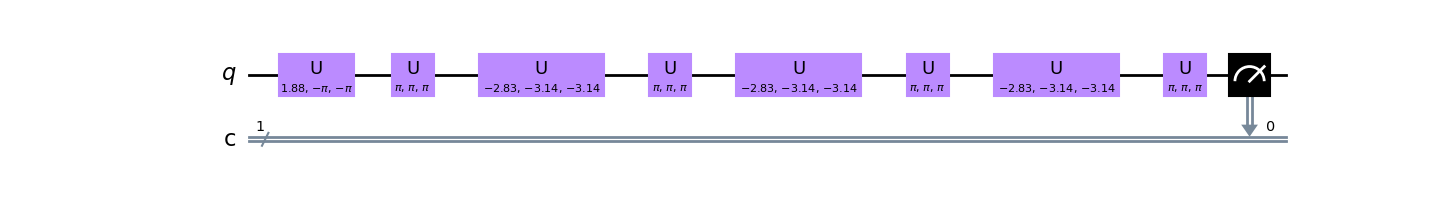

In [4]:
generator = QATG(circuitSize = 1, basisGateSet = [qGate.UGate], circuitInitializedStates = {1: [1, 0]}, minRequiredEffectSize = 2, verbose = True)
configurationList = generator.createTestConfiguration([myUFault([np.pi, np.pi, np.pi])])
for configuration in configurationList:
    print(configuration)
    configuration.circuit.draw('mpl')

In [1]:
!pip install libs_qrem
!pip install qiskit-ignis   
    

In [2]:
from qiskit import IBMQ
IBMQ.save_account('872395c64aae629a782c0f29e240279b70d8831a8a57be2271e6bc43a62dc9760e9029602bd94b411651319af154544a5fa015225362d0574d77d193720673b2', overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
def getNoiseModel_no_readouterror(self):
		# Depolarizing quantum errors
		oneQubitError = standard_errors.depolarizing_error(self.oneQubitErrorProb, 1)
		twoQubitError = standard_errors.depolarizing_error(self.twoQubitErrorProb, 2)
		qubitReadoutError = ReadoutError([self.zeroReadoutErrorProb, self.oneReadoutErrorProb])

		# Add errors to noise model
		noiseModel = NoiseModel()
		noiseModel.add_all_qubit_quantum_error(oneQubitError, self.basisGateSetString)
		noiseModel.add_all_qubit_quantum_error(twoQubitError, ['cx'])
		

		return noiseModel

In [58]:
from qiskit import QuantumRegister, Aer, execute
from qiskit.ignis.mitigation.measurement import tensored_meas_cal
import numpy as np
import qiskit.circuit.library as qGate
from qiskit.extensions import UnitaryGate
from qiskit.ignis.mitigation.measurement import TensoredMeasFitter
from qatg import QATG
from qatg import QATGFault
from libs_qrem import LeastNormFilter
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import standard_errors, ReadoutError

# prepare calibration circuit (same as qiskit tutorial)
class myUFault(QATGFault):
	def __init__(self, params):
		super(myUFault, self).__init__(qGate.UGate, 0, f"gateType: U, qubits: 0, params: {params}")
		self.params = params
	def createOriginalGate(self):
		return qGate.UGate(*self.params)
	def createFaultyGate(self, faultfreeGate):
		return qGate.UGate(faultfreeGate.params[0] - 0.1*np.pi, faultfreeGate.params[1], faultfreeGate.params[2])
generator = QATG(circuitSize = 1, basisGateSet = [qGate.UGate], circuitInitializedStates = {1: [1, 0]}, minRequiredEffectSize = 2, verbose = True)
configurationList = generator.createTestConfiguration([myUFault([np.pi, np.pi, np.pi])])

for configuration in configurationList:
    print(configuration)
    configuration.circuit.draw('mpl')
   
    n = 1
    qr = configuration.quantumRegister 
    mit_pattern = [[0]]
    meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
    backend = Aer.get_backend('aer_simulator')
    
    no_anynoise_job = execute(configuration.faultfreeQCKT, backend=backend, shots=200000)
    no_anynoise_results = no_anynoise_job.result()
    # Results without mitigation
    no_anynoise =no_anynoise_results.get_counts()
    print("no_anynoise")
    print(no_anynoise)
    
    no_readouterror_job = execute(meas_calibs, backend=backend, shots=200000,noise_model=getNoiseModel_no_readouterror(configuration))
    no_readouterror_cal_results = no_readouterror_job .result()
    print("no_readouterror")
    print(cal_results.get_counts())
    
    noise_job = execute(meas_calibs, backend=backend, shots=200000, noise_model=configuration.getNoiseModel())
    noise_cal_results = noise_job.result()
    noisy_hist = noise_job.result().get_counts()
    print("noisy_hist")
    print(noisy_hist)
    
    meas_fitter = TensoredMeasFitter(noise_cal_results, mit_pattern=mit_pattern)
    print("calibration matrices")
    print(meas_fitter.cal_matrices)
    
    meas_filter = LeastNormFilter(n, meas_fitter.cal_matrices)
    
   
    
    mitigated_hist = meas_filter.apply(noisy_hist)
    print("mitigated_hist")
    print(mitigated_hist)
    
    
    
    #Second time?
    
    
    job4 = execute(configuration.faultfreeQCKT, backend=backend, shots=200000,noise_model=getNoiseModel_no_readouterror(configuration))
    results4 = job4.result()
    # Results without mitigation
    no_noise = results4.get_counts()
    print("no_readouterror")
    print(no_noise)
    
    
    
    job3 = execute(configuration.faultfreeQCKT, backend=backend, shots=200000, noise_model=configuration.getNoiseModel())
    results3 = job3.result()
    
    # Results without mitigation
    raw_counts = results3.get_counts()

    # Get the filter object
    #meas_filter = meas_fitter.filter
    #print(meas_filter.cal_matrices)
    # Results with mitigation
    mitigated_results = meas_filter.apply(results3)
    mitigated_counts = mitigated_results.get_counts()
    print("raw_counts")
    print(raw_counts)
    print("mitigated_counts")
    print(mitigated_counts)


GS Parameter Score: 0.19098300562505274
GD Parameter Score: 0.19098300562191783
GD Step: 0
Current ParamterSet: [[1.8849517724935656, -3.1415945634200315, -3.141592653589793]]
Current effect size: 0.3791639787513044

GS Parameter Score: 0.6250015513436586
GD Parameter Score: 0.6909830041832262
GD Step: 27
Current ParamterSet: [[-2.8274409705767454, -3.1416919002604526, -3.141682239461847]]
Current effect size: 0.7968863722870106

GS Parameter Score: 1.184025766478124
GD Parameter Score: 1.3090169911148877
GD Step: 12
Current ParamterSet: [[-2.8274495440471235, -3.1416441176836685, -3.1416560289178896]]
Current effect size: 1.3294595246531753

GS Parameter Score: 1.6363005439085139
GD Parameter Score: 1.8090169897115338
GD Step: 7
Current ParamterSet: [[-2.8274430778431068, -3.141619466924457, -3.141617508328949]]
Current effect size: 2.2621513212401103

Target fault: { gateType: U, qubits: 0, params: [3.141592653589793, 3.141592653589793, 3.141592653589793] }
Length: 8	Repetition: 11	C